In [38]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,sample_id,item,publisher,user,topic_0,topic_1,topic_2,topic_3,topic_4,weight_0,weight_1,weight_2,weight_3,weight_4,target
0,0,531,147,2925,411,477,618,249,460,27,18,9,8,7,0
1,1,1574,260,2981,212,287,382,302,51,27,11,2,1,0,0
2,2,940,394,1230,145,150,212,170,174,7,6,6,5,5,0
3,3,52,520,2597,201,283,618,249,617,35,33,30,11,9,1
4,4,766,55,1680,362,150,477,305,388,51,15,13,10,9,1


In [4]:
test.head()

,sample_id,item,publisher,user,topic_0,topic_1,topic_2,topic_3,topic_4,weight_0,weight_1,weight_2,weight_3,weight_4
0,1009109,1716,349,1053,362,397,430,287,431,54,54,51,26,13
1,1009110,1707,202,254,150,73,356,212,482,29,7,5,5,4
2,1009111,1592,520,1524,397,287,356,330,281,95,46,6,5,3
3,1009112,1541,82,2994,397,287,102,323,356,93,77,25,7,4
4,1009113,52,520,936,201,283,618,249,617,35,33,30,11,9


In [5]:
# в датасете отсутствуют нули и вске типы одинаковые - int64
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009109 entries, 0 to 1009108
Data columns (total 15 columns):
sample_id    1009109 non-null int64
item         1009109 non-null int64
publisher    1009109 non-null int64
user         1009109 non-null int64
topic_0      1009109 non-null int64
topic_1      1009109 non-null int64
topic_2      1009109 non-null int64
topic_3      1009109 non-null int64
topic_4      1009109 non-null int64
weight_0     1009109 non-null int64
weight_1     1009109 non-null int64
weight_2     1009109 non-null int64
weight_3     1009109 non-null int64
weight_4     1009109 non-null int64
target       1009109 non-null int64
dtypes: int64(15)
memory usage: 115.5 MB


In [6]:
# соотношение класса 1 и 0 для столбца target
# около 20% класс 1, 80% класс 0
print(np.sum(train['target']==1)), \
print(np.sum(train['target']==0))

203628
805481


(None, None)

In [7]:
train.shape

(1009109, 15)

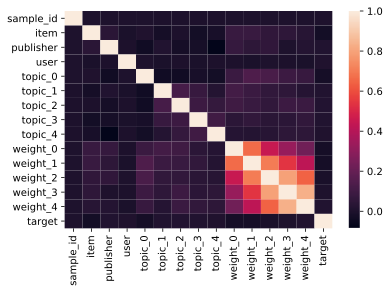

In [8]:
corr_train = train.corr()
sns.heatmap(corr_train);

In [ ]:
sns_plot = sns.pairplot(train)
#sns_plot.savefig('pairplot.png')

In [26]:
# разделим выборку на data_train и target_train. 
# В data_train будут все столбцы, кроме target. target_train будет состоять только из столбца target
#data_train = train.drop(train['target'], axis=0)
#cols = train.columns(train['target', 'weight_1', 'weight_2', 'weight_3', 'weight_4'])
data_train = train.drop(columns=['target', 'weight_1', 'weight_2', 'weight_3', 'weight_4'], axis=0)
target_train = train['target']

In [27]:
data_train.shape

(1009109, 10)

In [28]:
target_train.shape

(1009109,)

In [29]:
# разделим train на тестовую и обучающую с помощью train_test_split в соотношении 30% и 70% соответственно. 
# При обучении будем пользоваться кросс-валидацией на 5 фолдов
(X_train, 
 X_test, 
 y_train, y_test) = train_test_split(data_train, target_train, 
                                     test_size=0.3, 
                                     random_state=0)

In [35]:
cv = cross_val_score(regressor, X_train, y_train)

In [36]:
# обучение будет производиться логистической регрессией. Метрика качества logloss
regressor = LogisticRegression(penalty='l2')
regressor.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
boost = xgb.XGBRFRegressor()
boost.fit(X_train, y_train)
clf_probs = boost.predict(X_test)
score = log_loss(y_test, clf_probs)
print(score)

[15:52:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5012050691134731


In [37]:
clf_probs = regressor.predict(X_test)
score = log_loss(y_test, clf_probs)
print(score)

7.005690045450911


In [32]:
prediction = test[["sample_id"]]
prediction["target"] = np.random.rand(len(prediction))

In [33]:
prediction.head()

,sample_id,target
0,1009109,0.420810
1,1009110,0.012508
2,1009111,0.182278
3,1009112,0.543434
4,1009113,0.118573


In [34]:
prediction.to_csv("prediction.csv", index=False)